###This notebook is an addition to the Phillip-Farley's RR wavelength visualization <br>
STEP 1 I have only changed the lat and long to align with ifcb data from mvco dataset in dashboard <br>
STEP 2 read the IFCB file <br>
STEP 3 plot (part 1) identify the day from wavelengths<br>
STEP 4 plot (part 2) pick the genus distribution

In [1]:
import os
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
auth = earthaccess.login()
# are we authenticated?
if auth.authenticated:
    print("authenticated!")
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

authenticated!


In [3]:
results = earthaccess.search_datasets(instrument="oci")

In [4]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L2_BGC_NRT
PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_PAR_NRT
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_IOP_NRT
PACE_OCI_L3M_KD_NRT
PACE_OCI_L3M_PAR_NRT
PACE_OCI_L3M_POC_NRT
PACE_OCI_L3M_RRS_NRT


In [4]:
tspan = ("2024-07-01", "2024-08-25")

In [5]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    temporal=tspan,
    granule_name="*.DAY.*.0p1deg.*",
)

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/56 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/56 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/56 [00:00<?, ?it/s]

In [6]:
paths

[<File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240701.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240702.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240703.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240704.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240705.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240706.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatac

In [7]:
## STEP 1
#I HAVE MANIPULATED THE LAT and LONG in THIS CELL
import xarray as xr

# Use dask for lazy loading
combined_datasets = []
lon_east = -70.5
lon_west = -72.5
lat_north = 41.5
lat_south = 40.5
# Iterate over all the datasets
for i in range(1, len(paths)):
    # Open dataset without specifying chunks
    dataset = xr.open_dataset(paths[i])  # Load the dataset first

    # Rechunk the dataset after loading
    dataset = dataset.chunk({'lon': 'auto', 'lat': 'auto'})  # Use 'auto' or set specific sizes
    
    # Subset the dataset within the specified region and append to list
    subset = dataset.sel(lon=slice(lon_west, lon_east), lat=slice(lat_north, lat_south))
    combined_datasets.append(subset)

# Concatenate all subsets along the 'dataset' dimension
combined_dataset = xr.concat(combined_datasets, dim='dataset')

# Calculate the mean Rrs value across lon and lat for each dataset
average_per_dataset = combined_dataset.mean(dim=['lon', 'lat'])

In [9]:
average_per_dataset

<xarray.Dataset>
Dimensions:     (wavelength: 184, dataset: 55, rgb: 3, eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 339.0 341.0 344.0 ... 714.0 717.0 719.0
Dimensions without coordinates: dataset, rgb, eightbitcolor
Data variables:
    Rrs         (dataset, wavelength) float32 dask.array<chunksize=(1, 184), meta=np.ndarray>
    palette     (dataset, rgb, eightbitcolor) uint8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>

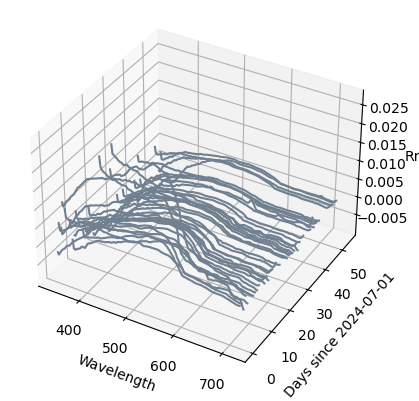

In [10]:
#THIS IS THE ORIGINAL PLOT WITH MY COORIDNATES
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Assuming average_per_dataset is already created using Dask
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract wavelengths and Rrs values at once to avoid repeated computation
wavelengths = average_per_dataset['wavelength'].values
rrs_values = average_per_dataset['Rrs'].compute()  # Trigger computation for all datasets

# Create y-coordinates for each dataset
y_indices = np.arange(rrs_values.shape[0])  # Create an array of dataset indices

# Plot in 3D space using a single color (e.g., slategray)
for dataset_index in range(rrs_values.shape[0]):
    ax.plot(wavelengths, np.full_like(wavelengths, y_indices[dataset_index]), rrs_values[dataset_index], color='slategray')

# Set axis labels
ax.set_xlabel('Wavelength')
ax.set_ylabel('Days since 2024-07-01')
ax.set_zlabel('Rrs')

# Rotate the plot 45 degrees along the Y-axis
ax.view_init(elev=35, azim=-60)

# Show the plot
plt.show()


###From here I have downloaded the IFCB csv file

In [12]:
##STEP 2
import pandas as pd
import numpy as np
difcb=pd.read_csv("https://github.com/oceanhackweek/ohw24_proj_pace_us/raw/main/contributor_folders/Gulce/mvco_difcb_data.csv")


# Assuming difcb is your DataFrame and the 'date' column is already in datetime format
# Convert the date column to datetime if it isn't already
difcb['date'] = pd.to_datetime(difcb['date'], format='%Y-%m-%d')  # Adjust format as needed

# Define the start date
start_date = pd.to_datetime("2024-07-01")

# Calculate the days since the start date
difcb['days_since_start'] = (difcb['date'] - start_date).dt.days

# Filter difcb data to match the region and time frame of interest
difcb_filtered = difcb[
    (difcb['latitude'] >= 40) & (difcb['latitude'] <= 41.5) &
    (difcb['longitude'] >= -72.5) & (difcb['longitude'] <= -70.5) &
    (difcb['days_since_start'] >= 0) & (difcb['days_since_start'] <= 16)
]

# Display the filtered DataFrame to verify the calculations
print(difcb_filtered.head())



        date         max_value_column  count  latitude  longitude  \
0 2024-07-01               Acantharia      1    41.362   -70.5226   
1 2024-07-01  Acanthoica_quattrospina   3739    41.362   -70.5226   
2 2024-07-01    Alexandrium_catenella     10    41.362   -70.5226   
3 2024-07-01                   Amoeba   1974    41.362   -70.5226   
4 2024-07-01              Amphidinium    285    41.362   -70.5226   

         genus  days_since_start  
0   Acantharia                 0  
1   Acanthoica                 0  
2  Alexandrium                 0  
3       Amoeba                 0  
4  Amphidinium                 0  


In [33]:
##STEP 3.1
#By hovering you can understand the which trace is the wavelength and find the date

import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt

# Extract the genus from the species name
difcb['genus'] = difcb['max_value_column'].str.split('_').str[0]

# Aggregate the counts by genus and date, and filter out counts less than 100
aggregated_data = (
    difcb.groupby(['date', 'genus'], as_index=False)
    .agg({'count': 'sum', 'latitude': 'first', 'longitude': 'first'})
    .query('count >= 100')
)

# Ensure aggregated_data only includes days within the first 30 days
aggregated_data['days_since_start'] = (pd.to_datetime(aggregated_data['date']) - pd.to_datetime("2024-07-01")).dt.days
aggregated_data = aggregated_data[aggregated_data['days_since_start'] <= 30]

# Assign a fixed wavelength (700 nm) and Rrs value (0.0) to all points
fixed_wavelength = 700
fixed_rrs_value = 0.0

# Create a Plotly figure
fig = go.Figure()

# Add Rrs data as before
for dataset_index in range(rrs_values.shape[0]):
    fig.add_trace(go.Scatter3d(
        x=wavelengths,
        y=[dataset_index] * len(wavelengths),
        z=rrs_values[dataset_index],
        mode='lines',
        line=dict(color='slategray'),
        showlegend=False
    ))

# Add species data points with hover info for each genus
for date in aggregated_data['date'].unique():
    days_since_start = (pd.to_datetime(date) - pd.to_datetime("2024-07-01")).days
    
    # Hover text now shows only the date
    hover_text = f"Date: {date}"

    fig.add_trace(go.Scatter3d(
        x=[fixed_wavelength],
        y=[days_since_start],
        z=[fixed_rrs_value],
        mode='markers',
        marker=dict(size=5, color='red'),
        hovertext=hover_text,
        hoverinfo='text',
        name=str(date)
    ))

# Set axis labels
fig.update_layout(
    scene=dict(
        xaxis_title='Wavelength (nm)',
        yaxis_title='Days since 2024-07-01',
        zaxis_title='Rrs',
    ),
    width=800,
    height=800,
    title="Interactive 3D Plot with Species Data"
)

# Show the plot
fig.show()


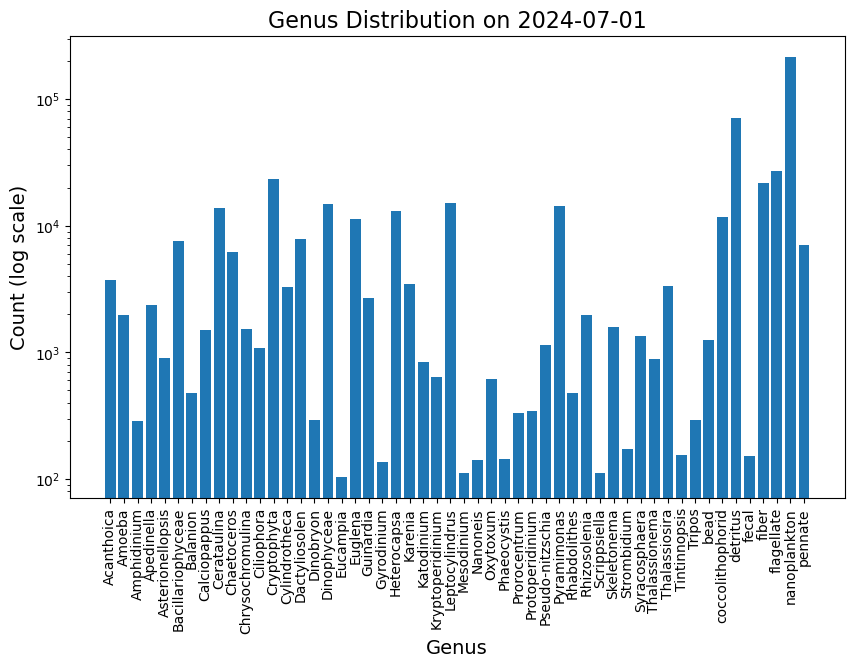

In [34]:
## STEP 3.2
# Function to create and display a bar graph for a specific day
def display_genus_distribution(date):
    species_data = aggregated_data[aggregated_data['date'] == date]
    
    # Create and display the genus distribution plot
    plt.figure(figsize=(10, 6))
    plt.bar(species_data['genus'], species_data['count'])
    plt.yscale('log')
    plt.title(f"Genus Distribution on {date}", fontsize=16)
    plt.xlabel('Genus', fontsize=14)
    plt.ylabel('Count (log scale)', fontsize=14)
    plt.xticks(rotation=90)
    plt.show()

# Example usage:
# After identifying a date in the plot, such as "2024-07-01", you can manually call:
display_genus_distribution('2024-07-01') #in here you can CHANGE the datE to look at genus distribution
